# Effective Dimension of Qiskit Neural Networks

In this tutorial, we will take advantage of the `EffectiveDimension` and `LocalEffectiveDimension` classes to evaluate the power of Quantum Neural Network models. These are metrics based on information geometry that connect to notions such as trainability, expressibility or ability to generalize.

Before diving into the code example, we will briefly explain what is the difference between these two metrics, and why are they relevant to the study of Quantum Neural Networks. More information about global effective dimension can be found in [this paper](https://arxiv.org/pdf/2011.00027.pdf), while the local effective dimension was introduced in a [later work](https://arxiv.org/abs/2112.04807).

## 1. Global vs. Local Effective Dimension

Both classical and quantum machine learning models share a common goal: being good at **generalizing**, i.e. learning insights from data and applying them on unseen data.

Finding a good metric to assess this ability is a non-trivial matter. In [The Power of Quantum Neural Networks](https://arxiv.org/pdf/2011.00027.pdf), the authors introduce the **global** effective dimension as a useful indicator of how well a particular model will be able to perform on new data.

The key difference between global and **local** effective dimension is actually not in the way they are computed, but in the nature of the parameter space that is analyzed. The global effective dimension incorporates the **full parameter space** of the model, and is calculated from a **large number of parameters sets**. On the other hand, the local effective dimension focuses on how well the **trained** model can generalize to new data, and thus only requires **1** set of parameters values (training result) for its calculation. This difference is small in terms of practical implementation, but quite relevant at a conceptual level.

## 2. The Effective Dimension Algorithm

Both the global and local effective dimension algorithms use the Fisher Information matrix to provide a measure of complexity. The details on how this matrix is calculated are provided in the [reference paper](https://arxiv.org/pdf/2011.00027.pdf), but in general terms, this matrix captures how sensitive a neural network's output is to changes in the network's parameter space.

In particular, this algorithm follows 4 main steps:

1. **Monte Carlo simulation:** the forward and backward passes (gradients) of the neural network are computed for each pair of input-parameter sets.
2. **Fisher Matrix Computation:** these outputs and gradients are used to compute the Fisher Information Matrix.
3. **Fisher Matrix Normalization:** averaging over all inputs and dividing by the matrix trace
4. **Effective Dimension Calculation:** according to the formula from [*Abbas et al.*](https://arxiv.org/pdf/2011.00027.pdf)

## 3. Basic Example (CircuitQNN)

This example shows how to set up a QNN model problem and run the global effective dimension algorithm. Both Qiskit `CircuitQNN` and `OpflowQNN` can be used with the `EffectiveDimension` class.



In [2]:
# Necessary imports
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.utils import QuantumInstance
from qiskit import Aer, QuantumCircuit

from qiskit_machine_learning.algorithms import EffectiveDimension, LocalEffectiveDimension

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA

In [3]:
# set random seed
np.random.seed(0)

The first step to create a `CircuitQNN` is to define a parametrized feature map and ansatz. In this toy example, we will use 3 qubits.

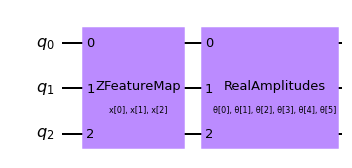

In [4]:
num_qubits = 3
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=1)

# create quantum circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw("mpl")

The parametrized circuit can then be sent together with an optional interpret map (parity in this case) to the `CircuitQNN` constructor.

In [5]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [6]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv,
)

### 2. Define the Problem

In order to define the problem, we need a series of sets of inputs and parameters, as well as the total number of data (`num_samples`). The `inputs` and `params` are set in the class constructor, while the number of data is given during the call to the effective dimension computation to be able to test and compare how this measure changes with different dataset sizes.

In [7]:
# we can set a callback to see how long each QNN pass takes duting the Monte Carlo simulation
def callback(msg):
    print(msg)

We can define the number of input and parameters sets and the class will randomly sample a corresponding array from a normal (for `inputs`) or a uniform (for `params`) distribution.

In [8]:
# we can set the total number of input and parameter sets for random selection
num_inputs = 10
num_params = 10

global_ed = EffectiveDimension(
    qnn=qnn, num_params=num_params, num_inputs=num_inputs, callback=callback
)

However, if we want to test a specific set of input and parameter values, we can provide it directly to the `EffectiveDimension` class as shown in the following snippet:

In [9]:
# we can also provide user-defined inputs and parameters
inputs = np.random.normal(0, 1, size=(10, qnn.num_inputs))
params = np.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, params=params, inputs=inputs, callback=callback)

The effective dimension algorithm also requires a dataset size. In this example, we will define an array of sizes to later see how this input affects the result.

In [10]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

### 3. Compute the Global Effective Dimension

Let's now calculate the effective dimension of our network for the previously defined set of inputs, parameters, and a dataset size of 5000. The previously defined callback function will show the time each pass takes in the Monte Carlo simulation.

In [11]:
global_eff_dim_0 = global_ed.get_effective_dimension(num_samples=n[0])

iteration 0, time forward pass: 0.026492834091186523
iteration 0, time backward pass: 0.3932678699493408
iteration 1, time forward pass: 0.02126622200012207
iteration 1, time backward pass: 0.375471830368042
iteration 2, time forward pass: 0.021595001220703125
iteration 2, time backward pass: 0.29033398628234863
iteration 3, time forward pass: 0.023179054260253906
iteration 3, time backward pass: 0.2225649356842041
iteration 4, time forward pass: 0.020126819610595703
iteration 4, time backward pass: 0.39411425590515137
iteration 5, time forward pass: 0.012490987777709961
iteration 5, time backward pass: 0.20885396003723145
iteration 6, time forward pass: 0.017184019088745117
iteration 6, time backward pass: 0.22853612899780273
iteration 7, time forward pass: 0.012450218200683594
iteration 7, time backward pass: 0.38118910789489746
iteration 8, time forward pass: 0.02593684196472168
iteration 8, time backward pass: 0.19982314109802246
iteration 9, time forward pass: 0.01999211311340332


The effective dimension values will range between 0 and `d`, where `d` represents the dimension of the model, and it's practically obtained from the number of weights of the QNN. By dividing the result by `d`, we can obtain the normalized effective dimension, which correlates directly with the capacity of the model.

In [12]:
d = global_ed.num_weights()

print("data size: {}, global effective dim: {:.4f}".format(n[0], global_eff_dim_0))
print("d: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0/d))

data size: 5000, global effective dim: 4.3902
d: 6, normalized effective dimension: 0.7317


By calling the `EffectiveDimension` class with an array if input sizes `n`, we can monitor how the effective dimension changes with the dataset size.

In [13]:
global_eff_dim_1 = global_ed.get_effective_dimension(num_samples=n)

iteration 0, time forward pass: 0.014568090438842773
iteration 0, time backward pass: 0.356719970703125
iteration 1, time forward pass: 0.017597198486328125
iteration 1, time backward pass: 0.2297201156616211
iteration 2, time forward pass: 0.017418861389160156
iteration 2, time backward pass: 0.21870708465576172
iteration 3, time forward pass: 0.02727818489074707
iteration 3, time backward pass: 0.4651219844818115
iteration 4, time forward pass: 0.03027510643005371
iteration 4, time backward pass: 0.22983098030090332
iteration 5, time forward pass: 0.018191099166870117
iteration 5, time backward pass: 0.2549591064453125
iteration 6, time forward pass: 0.019792795181274414
iteration 6, time backward pass: 0.4149661064147949
iteration 7, time forward pass: 0.01211690902709961
iteration 7, time backward pass: 0.2606329917907715
iteration 8, time forward pass: 0.02452683448791504
iteration 8, time backward pass: 0.31026697158813477
iteration 9, time forward pass: 0.021975994110107422
iter

In [14]:
print("effdim: {}".format(global_eff_dim_1))
print("d: {}".format(d))

effdim: [4.39023708 4.44945007 4.47943325 4.67392133 4.72931109 4.7962052
 4.84657168 4.88071983 4.98045016 5.04700965]
d: 6


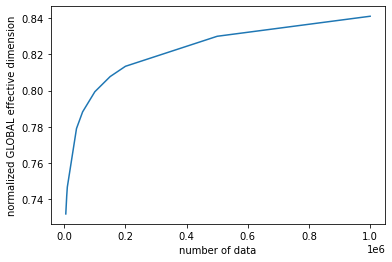

In [15]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("number of data")
plt.ylabel("normalized GLOBAL effective dimension")
plt.show()

## 3. Local Effective Dimension Example

As explained in the introduction, the local effective dimension algorithm only uses **one** set of parameters. The `LocalEffectiveDimension` class enforces this constraint to ensure that these calculations are conceptually separate, but the rest of the implementation is shared with the `EffectiveDimension` class.

Let's see how the `LocalEffectiveDimension` changes when we train a QNN for classification.

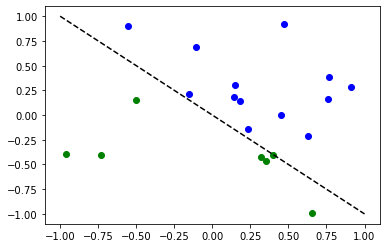

In [16]:
# STEP 1: CREATE CLASSIFICATION DATASET

num_inputs = 2
num_samples = 20

X = 2 * np.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [ ]:
# STEP 2: CREATE QNN

# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=qi_sv)

In [ ]:
# STEP 3: TRAIN QNN

# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=opflow_qnn, optimizer=COBYLA(),
)

# fit classifier to data
out = circuit_classifier.fit(X, y01)

# extract trained weights
trained_weights = out._fit_result.x

In [ ]:
# STEP 4: GET LOCAL EDs

# Get Local Effective Dimension for random set of parameters
rand_params = np.random.uniform(0, 1, size=(1, opflow_qnn.num_weights))

local_ed_0 = LocalEffectiveDimension(
    qnn=opflow_qnn, params=rand_params, inputs=X  # send only one set of parameters
)
local_eff_dim_0 = local_ed_0.get_effective_dimension(num_samples=n)

In [ ]:
# Get Local Effective Dimension for set of trained parameters
local_ed_1 = LocalEffectiveDimension(
    qnn=opflow_qnn, params=trained_weights, inputs=X  # send only one set of parameters
)

local_eff_dim_1 = local_ed_1.get_effective_dimension(num_samples=n)

In [ ]:
print(local_eff_dim_0)
print(local_eff_dim_1)

In [ ]:
# plot the normalized effective dimension for the model
d = local_ed_1.num_weights()

plt.plot(n, np.array(local_eff_dim_0) / d, label='random params') # random
plt.plot(n, np.array(local_eff_dim_1) / d, label='trained params') # trained
plt.legend()
plt.xlabel("number of data")
plt.ylabel("normalized LOCAL effective dimension")
plt.show()

We can see from the graph above that the trained weights lead to a higher local effective dimension, because the ability to classify new data points is higher. Following this example, we can establish comparisons between different  model architectures (for a fixed input dataset), optimizers... And try to find the combination that maximizes the local effective dimension.